In [1]:
import math
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def build_graph(df: pd.DataFrame) -> nx.MultiDiGraph:
    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        row_data = row.to_dict()
        G.add_edge(row_data.pop("from"), row_data.pop("to"), **row_data, direction="directed" if row["confirmed"] else "undirected")
    return G

def draw_graph(G: nx.DiGraph) -> None:
    pos = nx.planar_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['confirmed']])
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in G.edges(data=True) if not d['confirmed']], style="dashed", arrowstyle="-")
    plt.show()

def calc_trace(m: np.ndarray) -> float:
    return np.linalg.eigvals(m).sum()

def tracial_dependency_ratio(x: np.ndarray, w: np.ndarray) -> float:
    cov_x = np.cov(x.T)
    return calc_trace(w.dot(cov_x).dot(w.T)) / (calc_trace(w.dot(w.T)) * calc_trace(cov_x))

In [3]:
class NodeRegression(torch.nn.Module):
    def __init__(
        self,
        P: int,
        D: int,
        H: int,
        seed: int = 42,
        dtype: torch.dtype = torch.float64,
    ):
        super().__init__()
        torch.manual_seed(seed)
        self.A = torch.nn.Parameter(torch.rand((P, H, D), dtype=dtype))
        self.B = torch.nn.Parameter(torch.rand((D, H * P), dtype=dtype))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.A @ torch.as_tensor(x).unsqueeze(2).transpose(-1, -2)
        return h.reshape(len(x), -1) @ self.B.T

    def get_parent_weights(self, i: int) -> np.ndarray:
        return self.A[i].detach().numpy()

    def fit(self, target: torch.Tensor, parents: list[torch.Tensor]) -> "NodeRegression":
        lr = 0.01
        n_epochs = 500
        batch_size = 1000
        n_epoch_prints = 5
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        x = torch.stack([torch.as_tensor(p) for p in parents], axis=1)
        y = torch.as_tensor(target)
        n_batches = math.ceil(len(target) / batch_size)

        for epoch in range(n_epochs):
            for batch_idx in range(n_batches):
                start = batch_size * batch_idx
                end = start + batch_size
                loss = criterion(self.forward(x[start:end]), y[start:end])
        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            if (epoch + 1) % int(n_epochs / n_epoch_prints) == 0 or not epoch:
                print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")
        
        return self

In [4]:
N = 10000  # sample size
D = 2  # embedding dimension
H = 3  # hidden state dimension

In [5]:
np.random.seed(42)

z = Nz = np.random.normal(1, 5, (N, D))
w = Nw = np.random.normal(1, 5, (N, D))

Wzx = np.random.randn(H, D)
Nzx = np.random.normal(0, 1, (N, H))
Hzx = z.dot(Wzx.T) + Nzx

Wx = np.random.randn(D, 1 * H)
Nx = np.random.normal(0, 1, (N, D))
x = np.concatenate([Hzx]).dot(Wx.T) + Nx

Wxy = np.random.randn(H, D)
Nxy = np.random.normal(0, 1, (N, H))
Hxy = x.dot(Wxy.T) + Nxy

Wwy = np.random.randn(H, D)
Nwy = np.random.normal(0, 1, (N, H))
Hwy = w.dot(Wwy.T) + Nwy

Wy = np.random.randn(D, 2 * H)
Ny = np.random.normal(0, 1, (N, D))
y = np.concatenate([Hxy, Hwy], axis=1).dot(Wy.T) + Ny

In [6]:
df = pd.DataFrame(
    columns=["from", "to", "confirmed", "score_yes", "score_no"],
    data=[
        ["w", "y", True, None, None],
        ["x", "y", True, None, None],
        ["z", "x", True, None, None],
    ],
)

df

,from,to,confirmed,score_yes,score_no
0,w,y,True,None,None
1,x,y,True,None,None
2,z,x,True,None,None


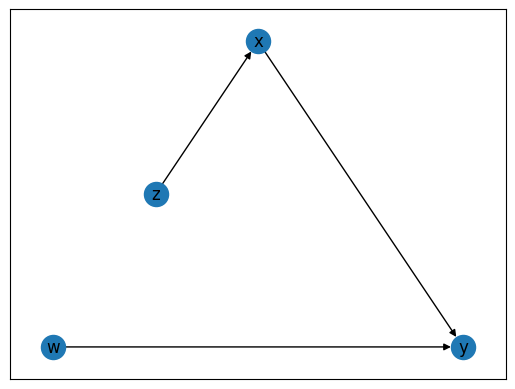

In [7]:
G = build_graph(df)
draw_graph(G)

In [8]:
r_y_on_xw = NodeRegression(2, D, H).fit(target=y, parents=[x, w])

r_x_on_zy = NodeRegression(2, D, H).fit(target=x, parents=[z, y])

r_w_on_y =  NodeRegression(1, D, H).fit(target=w, parents=[y,  ])

r_z_on_x =  NodeRegression(1, D, H).fit(target=z, parents=[x,  ])

Epoch [1/500], Loss: 383.3668
Epoch [100/500], Loss: 3.2585
Epoch [200/500], Loss: 3.2567
Epoch [300/500], Loss: 3.2566
Epoch [400/500], Loss: 3.2558
Epoch [500/500], Loss: 3.2526
Epoch [1/500], Loss: 157.1839
Epoch [100/500], Loss: 2.1043
Epoch [200/500], Loss: 2.1052
Epoch [300/500], Loss: 2.1071
Epoch [400/500], Loss: 2.1109
Epoch [500/500], Loss: 2.1158
Epoch [1/500], Loss: 28.3286
Epoch [100/500], Loss: 13.5006
Epoch [200/500], Loss: 13.5000
Epoch [300/500], Loss: 13.4967
Epoch [400/500], Loss: 13.4938
Epoch [500/500], Loss: 13.4919
Epoch [1/500], Loss: 33.8976
Epoch [100/500], Loss: 8.3841
Epoch [200/500], Loss: 8.3840
Epoch [300/500], Loss: 8.3836
Epoch [400/500], Loss: 8.3832
Epoch [500/500], Loss: 8.3829


In [9]:
print("x -> y", tracial_dependency_ratio(x, r_y_on_xw.get_parent_weights(0)))
print("y -> x", tracial_dependency_ratio(y, r_x_on_zy.get_parent_weights(1)))
print()
print("z -> x", tracial_dependency_ratio(z, r_x_on_zy.get_parent_weights(0)))
print("x -> z", tracial_dependency_ratio(x, r_z_on_x.get_parent_weights(0)))
print()
print("w -> y", tracial_dependency_ratio(w, r_y_on_xw.get_parent_weights(1)))
print("y -> w", tracial_dependency_ratio(y, r_w_on_y.get_parent_weights(0)))

x -> y 0.5988535549885569
y -> x 0.10633592731045893

z -> x 0.49781894624419376
x -> z 0.20900154760310924

w -> y 0.4945228050680472
y -> w 0.16435286988567085
